# Renewable power generation for Germany
## Data exploration and enrichment

The transition to a fully renewable energy generation is a current challenge for Germany. At the moment (first quarter of 2022) 47,9% of the energy consumed was generated by solar, wind, water and biomass (see https://www.smard.de/page/home/topic-article/444/207508). The amount of generated renewable energy is very volatile, though, and depends mostly on weather conditions such as wind and sunshine intensity. Since the grid that transports the generated powert to consumers must be balanced at all times, it is very important to predict as precise as possible how much power will be generated. Also the electicity price at the spot market is highly influenced by amount of the renewable energy produced. So in this way the price at the spot market is forecasted indirectly as well. In this notebook I want to explore, if there are any patterns of the renewable power generation (I want to look at the total renewable power generation, i.e. the sum of solar, wind, water and biomass) and how these correlate with weather conditions. 

** Of course, for the stability of the grid not only the total amount of the power generated in whole Germany is, but how much energy is generated at different locations. Well, since I do not have the data of a special location, I will build the model for the entire German renewable energy production. **

### libraries, load data

First I import the necessary libraries and load the data. I have downloaded the energy generation data by energy type from the official site of the German Federal Network Agency here: www.smard.de. The data is provided with a resolutio of 15 minutes, i.e. there is a record for every 15 minutes. It is possible to select a maximum of two years of data. Since I want to use four years of data for training and testing, I have downloaded two times two years of data, so that my first record is on January 15th of 2018 and the last on January 15th of 2022.

In [2]:
# necessary libraries
import pandas as pd
import os
from datetime import datetime
import numpy as np

#for visualisations
from matplotlib import pyplot as plt
%matplotlib inline
import seaborn as sns
import plotly.express as px

In [39]:
# for the forecast model
import prophet

In [ ]:
# access the weather data through api meteostat
!pip install meteostat
from meteostat import Hourly
from meteostat import Point

In [3]:
# set the data source path and files variables
data_path = '/home/olga/Downloads/'
file1 = 'Realisierte_Erzeugung_202001150000_202201152359.csv' 
file2 = 'Realisierte_Erzeugung_201801150000_202001142359.csv'

In [5]:
# merge the two csv files
df1 = pd.read_csv(os.path.join(data_path, file1), sep=';')
df2 = pd.read_csv(os.path.join(data_path, file2), sep=';')
df = pd.concat([df2, df1], ignore_index=True)

/home/olga/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3326: DtypeWarning: Columns (2,3,8,9) have mixed types.Specify dtype option on import or set low_memory=False.
  exec(code_obj, self.user_global_ns, self.user_ns)


In [6]:
# get first impression of the data
df.head(10)

,Datum,Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Pumpspeicher[MWh],Sonstige Konventionelle[MWh]
0,15.01.2018,00:00,"1.210,5","433,25",711.0,3.926,0.0,58,"2.267,5",4.149,939.0,1.127,191.0,289.0
1,15.01.2018,00:15,"1.210,25","433,5",768.0,3.965,0.0,58,"2.266,25",4.102,932.0,1.087,11.0,288.0
2,15.01.2018,00:30,"1.210,25",426,782.0,3.973,0.0,58,"2.262,75",4.083,927.0,1.077,171.0,288.0
3,15.01.2018,00:45,1.212,"422,25",772.0,4.015,0.0,58,"2.258,25",4.071,926.0,1.073,15.0,290.0
4,15.01.2018,01:00,"1.209,25",423,768.0,4.027,0.0,58,"2.267,75",4.079,900.0,1.075,191.0,288.0
5,15.01.2018,01:15,"1.208,5","421,25",836.0,4.095,0.0,58,"2.265,25",4.060,892.0,1.073,172.0,288.0
6,15.01.2018,01:30,"1.210,25","420,25",876.0,4.124,0.0,58,"2.262,5",4.035,876.0,1.071,168.0,288.0
7,15.01.2018,01:45,1.210,418,874.0,4.152,0.0,58,"2.257,25",4.006,872.0,1.072,155.0,288.0
8,15.01.2018,02:00,"1.209,25",424,863.0,4.143,0.0,58,"2.256,25",4.014,875.0,1.066,15.0,289.0
9,15.01.2018,02:15,"1.209,75",436,869.0,4.139,0.0,58,"2.250,25",3.990,866.0,1.064,11.0,290.0


In [7]:
df.tail()

,Datum,Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh],Kernenergie[MWh],Braunkohle[MWh],Steinkohle[MWh],Erdgas[MWh],Pumpspeicher[MWh],Sonstige Konventionelle[MWh]
140347,15.01.2022,22:45,1.132,311,715.0,1.011,0.0,52,1.006,3.316,2.910,2.092,57.0,387.0
140348,15.01.2022,23:00,1.132,320,742.0,983.000,0.0,52,1.006,3.299,2.863,1.933,170.0,382.0
140349,15.01.2022,23:15,1.132,315,759.0,957.000,0.0,52,1.006,3.265,2.842,1.794,229.0,381.0
140350,15.01.2022,23:30,1.131,314,770.0,955.000,0.0,52,1.006,3.264,2.861,1.700,157.0,382.0
140351,15.01.2022,23:45,1.13,313,803.0,966.000,0.0,52,1.005,3.256,2.859,1.597,100.0,381.0


In the energy production data is one column for the date (Datum) and one column for the time (Uhrzeit) and there is a data point for every 15 minutes. When reading in the data I will convert these two colunms to one containing the datetime with the option parse_dates=[['Datum', 'Uhrzeit']].
And also the numerical columns seem to be formatted as usual in Germany: a dot is used to make the thousands more readable, i.e. the entry 1.132 means one 'thousand one hundred thirty two' and not 'one point one three two'. (see the graphics on www.smard.de for comparison of the scales). Check, if pandas interprets the dots as a decimal separator.  

In [8]:
df['sumWasserkraft'] = df[['Wind Offshore[MWh]', 'Wind Onshore[MWh]']].sum(axis=1)
df[['Wind Offshore[MWh]', 'Wind Onshore[MWh]', 'sumWasserkraft']].head()

,Wind Offshore[MWh],Wind Onshore[MWh],sumWasserkraft
0,711.0,3.926,714.926
1,768.0,3.965,771.965
2,782.0,3.973,785.973
3,772.0,4.015,776.015
4,768.0,4.027,772.027


Yes, the dot is interpreted by Pandas as a decimal separator (and for the 'Wind Offshore[MWh]' it actually is correctly a decimal separator, whereas for the 'Wind Onshore[MWh]' it is not. To correct this I need to reload the data and specify the option thousands='.' in read_csv(), so that the numbers will be interpreted correctly. 
Since the date column ('Datum') is formatted in the German date format, also containing a dot between day, month and year respectively, I need to use the converters option for read_csv(). See also here: https://stackoverflow.com/questions/62872697/how-to-open-a-german-csv-file-with-pandas.  

In [4]:
# write a function that reads in the renewable energy generation data for Germany 

def load_data(datapath, files, usecols):
    ''' This function takes as arguments the data files. This function reads in the data from multiple
        files (taking care of the German formats for the date and numerical variables) and appends 
        the data sets into one dataframe.'''
    
    # for handling the German date format define converters for read_csv
    converters = {'Datum': lambda x: pd.to_datetime(x, format='%d.%m.%Y')}

    df = pd.DataFrame()
    for file in files:
        print('reading in data:', file)
        df = df.append(pd.read_csv(os.path.join(datapath, file), sep=';', thousands='.', decimal=',', 
                    converters=converters, usecols=usecols, parse_dates=[['Datum', 'Uhrzeit']]), 
                    ignore_index=True)
        print('the shape of the dataframe is:', df.shape)
    
    print('Loading process finished.')
    return df
    

In [5]:
files = [file2, file1]
# I only need the renewables and the date and time fields 
renewables = ['Biomasse[MWh]', 'Wasserkraft[MWh]', 'Wind Offshore[MWh]', 'Wind Onshore[MWh]', 'Photovoltaik[MWh]', 'Sonstige Erneuerbare[MWh]']
df = load_data(datapath=data_path, files=files, usecols=['Datum', 'Uhrzeit']+renewables)

reading in data: Realisierte_Erzeugung_201801150000_202001142359.csv
the shape of the dataframe is: (70080, 7)
reading in data: Realisierte_Erzeugung_202001150000_202201152359.csv
the shape of the dataframe is: (140352, 7)
Loading process finished.


In [5]:
# check if the loaded data looks ok
df.head()

,Datum_Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh]
0,2018-01-15 00:00:00,1210.50,433.25,711,3926,0,58
1,2018-01-15 00:15:00,1210.25,433.50,768,3965,0,58
2,2018-01-15 00:30:00,1210.25,426.00,782,3973,0,58
3,2018-01-15 00:45:00,1212.00,422.25,772,4015,0,58
4,2018-01-15 01:00:00,1209.25,423.00,768,4027,0,58


In [6]:
df.tail()

,Datum_Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh]
140347,2022-01-15 22:45:00,1132.0,311.0,715,1011,0,52
140348,2022-01-15 23:00:00,1132.0,320.0,742,983,0,52
140349,2022-01-15 23:15:00,1132.0,315.0,759,957,0,52
140350,2022-01-15 23:30:00,1131.0,314.0,770,955,0,52
140351,2022-01-15 23:45:00,1130.0,313.0,803,966,0,52


## Data Exploration
Now that the data is loaded in the correct format, I want to validate its quality. First I check, if there are missing values.

In [7]:
#check if there are null values
for source in renewables:
    print('number of null values for ' + source + ':' + str(df[source].isnull().sum()))

number of null values for Biomasse[MWh]:0
number of null values for Wasserkraft[MWh]:0
number of null values for Wind Offshore[MWh]:0
number of null values for Wind Onshore[MWh]:0
number of null values for Photovoltaik[MWh]:0
number of null values for Sonstige Erneuerbare[MWh]:0


Very good, there are no missing values!

In [8]:
# check the statistics for the columns
df.describe()

,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh]
count,140352.000000,140352.000000,140352.000000,140352.000000,140352.000000,140352.000000
mean,1144.762305,434.845661,676.311125,2724.629973,1251.938490,43.802340
std,61.866552,91.059819,464.799092,2166.711707,1920.952892,8.120243
min,925.750000,217.000000,0.000000,24.000000,0.000000,28.000000
25%,1098.000000,362.000000,248.000000,1059.000000,0.000000,37.000000
50%,1145.000000,429.500000,635.000000,2076.000000,22.000000,43.000000
75%,1201.500000,506.250000,1060.000000,3833.000000,2019.000000,51.000000
max,1264.000000,741.250000,1816.000000,10580.000000,9096.000000,62.000000


Seems reasonable. Wind Onshore has the bigges standard deviation, next solar. It is know that the wind onshore is very volatile and the sun power generation is always 0 at night and is sometimes really high around noon. Also that the Wind Onshore contributes most to the renewable power generation is plausible. Only why the minimum for Wind Offshore is 0?

In [9]:
# find the data points where the wind offshore is 0
df.loc[df['Wind Offshore[MWh]'] == 0]

,Datum_Uhrzeit,Biomasse[MWh],Wasserkraft[MWh],Wind Offshore[MWh],Wind Onshore[MWh],Photovoltaik[MWh],Sonstige Erneuerbare[MWh]
52651,2019-07-17 11:45:00,1104.0,491.0,0,119,5651,36
52652,2019-07-17 12:00:00,1100.0,534.0,0,119,5807,35
52655,2019-07-17 12:45:00,1097.0,484.0,0,137,5965,35
52656,2019-07-17 13:00:00,1088.0,543.0,0,151,5997,35
52658,2019-07-17 13:30:00,1088.0,535.0,0,172,5902,35
...,...,...,...,...,...,...,...
138654,2021-12-29 07:30:00,1088.0,346.0,0,3143,0,44
138657,2021-12-29 08:15:00,1096.0,344.0,0,2985,6,51
138658,2021-12-29 08:30:00,1096.0,345.0,0,2925,30,52
138659,2021-12-29 08:45:00,1095.0,336.0,0,2872,72,52


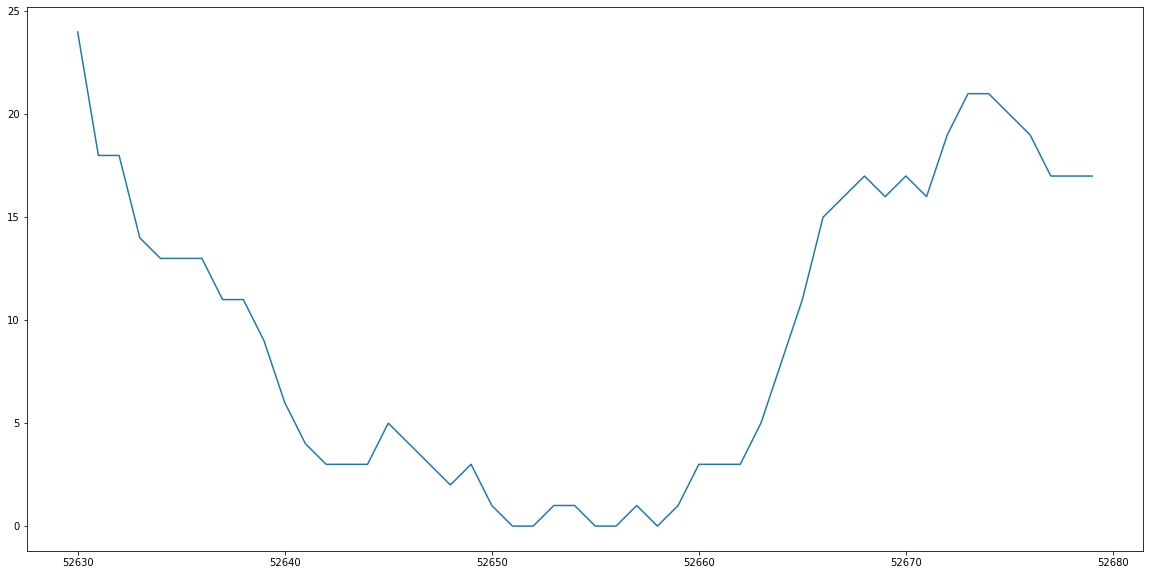

In [64]:
# plot the time-series around that point 
plt.rcParams['figure.figsize'] = [20, 10]
df['Wind Offshore[MWh]'].iloc[52630:52680].plot()
plt.show()

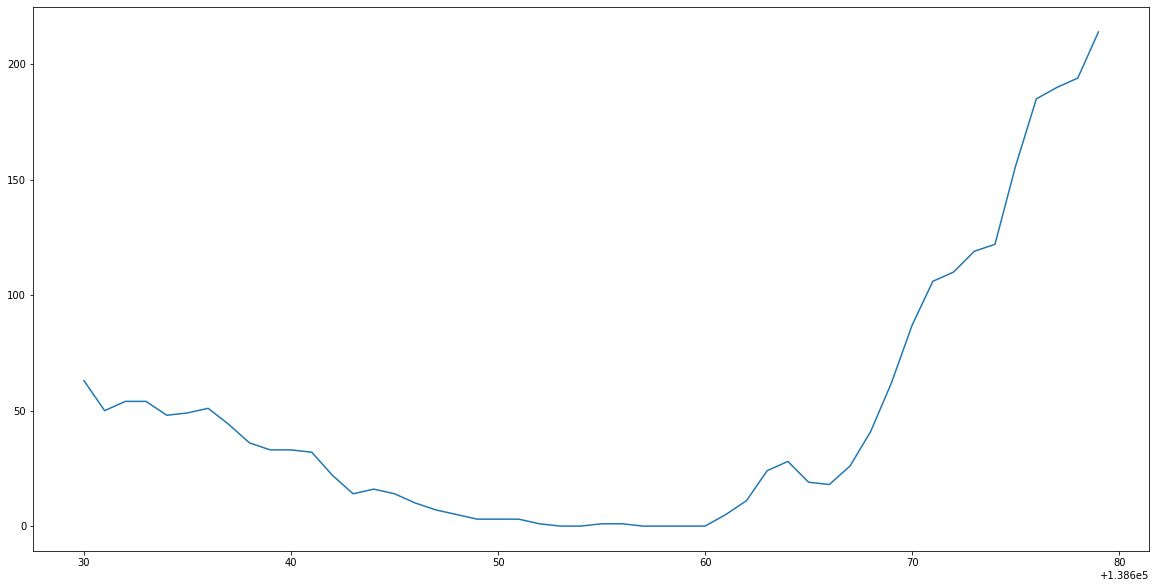

In [62]:
plt.rcParams['figure.figsize'] = [20, 10]
df['Wind Offshore[MWh]'].iloc[138630:138680].plot()
plt.show()

seems like there is just little wind or wind power production was turned off during that time and not a data issue.

Since I want to analyze the total amount of the reneable energy, I only need to look at the sum of the renewable power generation. I will call this field 'y', because fbprophet requires the target variable to be named so.
And also, I want to forecast hourly power generation, so I will downsample to hourly values (the dataframe now contains the power generation for every 15 minutes). The downsampled data will contain the average renewable power generation for every hour/during every hour.

In [6]:
# sum the individual renewable sources into the target variable y
df['y'] = df[renewables].sum(axis=1)
df_renew = df[['Datum_Uhrzeit', 'y']]

In [7]:
df_renew.head(10)

,Datum_Uhrzeit,y
0,2018-01-15 00:00:00,6338.75
1,2018-01-15 00:15:00,6434.75
2,2018-01-15 00:30:00,6449.25
3,2018-01-15 00:45:00,6479.25
4,2018-01-15 01:00:00,6485.25
5,2018-01-15 01:15:00,6618.75
6,2018-01-15 01:30:00,6688.50
7,2018-01-15 01:45:00,6712.00
8,2018-01-15 02:00:00,6697.25
9,2018-01-15 02:15:00,6711.75


In [8]:
# set the timestamp as index
df_renew = df_renew.set_index('Datum_Uhrzeit')
df_renew.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 140352 entries, 2018-01-15 00:00:00 to 2022-01-15 23:45:00
Data columns (total 1 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   y       140352 non-null  float64
dtypes: float64(1)
memory usage: 2.1 MB


In [9]:
# downsample to hourly datapoints with 
# sum: total amount of energy produced during that hour
# mean: mean amount of energy produced during that hour at every time point
# because of troubles with daylight saving time take the mean
resample = df_renew.resample('H')
hourly_renew = resample.mean()
hourly_renew.head()

,y
Datum_Uhrzeit,
2018-01-15 00:00:00,6425.5000
2018-01-15 01:00:00,6626.1250
2018-01-15 02:00:00,6688.2500
2018-01-15 03:00:00,6787.1875
2018-01-15 04:00:00,7019.0625


Interpretation of this time-series: 
During the hour between 00:00 and 01:00 the renewable energy sources produced an average of 6425.5 MWh.


'During the hour between 00:00 and 01:00 25702 MWh renewable energy was produced in Germany, during the hour between 01:00 and 02:00 a total amount of 26504.5 MWh renewable energy was generated in Germany and so on.

In [10]:
hourly_renew.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 35088 entries, 2018-01-15 00:00:00 to 2022-01-15 23:00:00
Freq: H
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   y       35084 non-null  float64
dtypes: float64(1)
memory usage: 548.2 KB


In [11]:
hourly_renew.describe()

,y
count,35084.000000
mean,6276.167299
std,2806.152487
min,1620.250000
25%,3979.437500
50%,5840.250000
75%,8176.000000
max,16839.250000


Now we have a count of 35084 non-null values, but in the total amount of values is 35088. What are the null values? Where do these come from? Must be the one missing due to daylight saving time every last sunday in March (4 years of data -> 4 missing values).

In [12]:
# check the missing values
hourly_renew.loc[hourly_renew['y'].isnull()]

,y
Datum_Uhrzeit,
2018-03-25 02:00:00,NaN
2019-03-31 02:00:00,NaN
2020-03-29 02:00:00,NaN
2021-03-28 02:00:00,NaN


ok, it's missing, which also kind of makes sense, because there is no value due to the daylight saving time switch end of March every year. For prophet it's no problem, if a value is missing (see here: https://github.com/facebook/prophet/issues/854)

# visualize the time series

In [13]:
# set the plot parameters
plt.rcParams['figure.figsize'] = [30, 10]

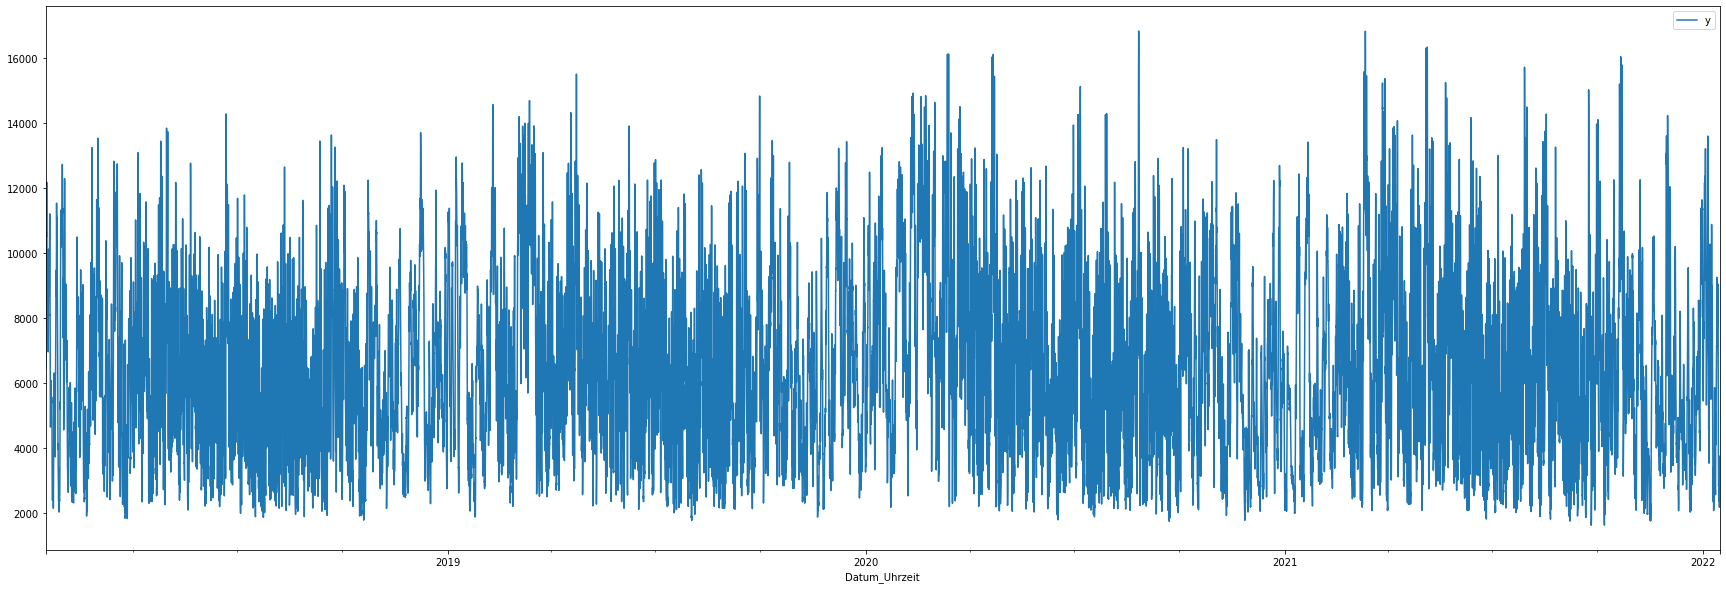

In [14]:
# plot the transformed series
hourly_renew.plot()

It's difficult to see anything from those many datapoints. There are just to many to show them all in a graph. Let's visualize for each year.

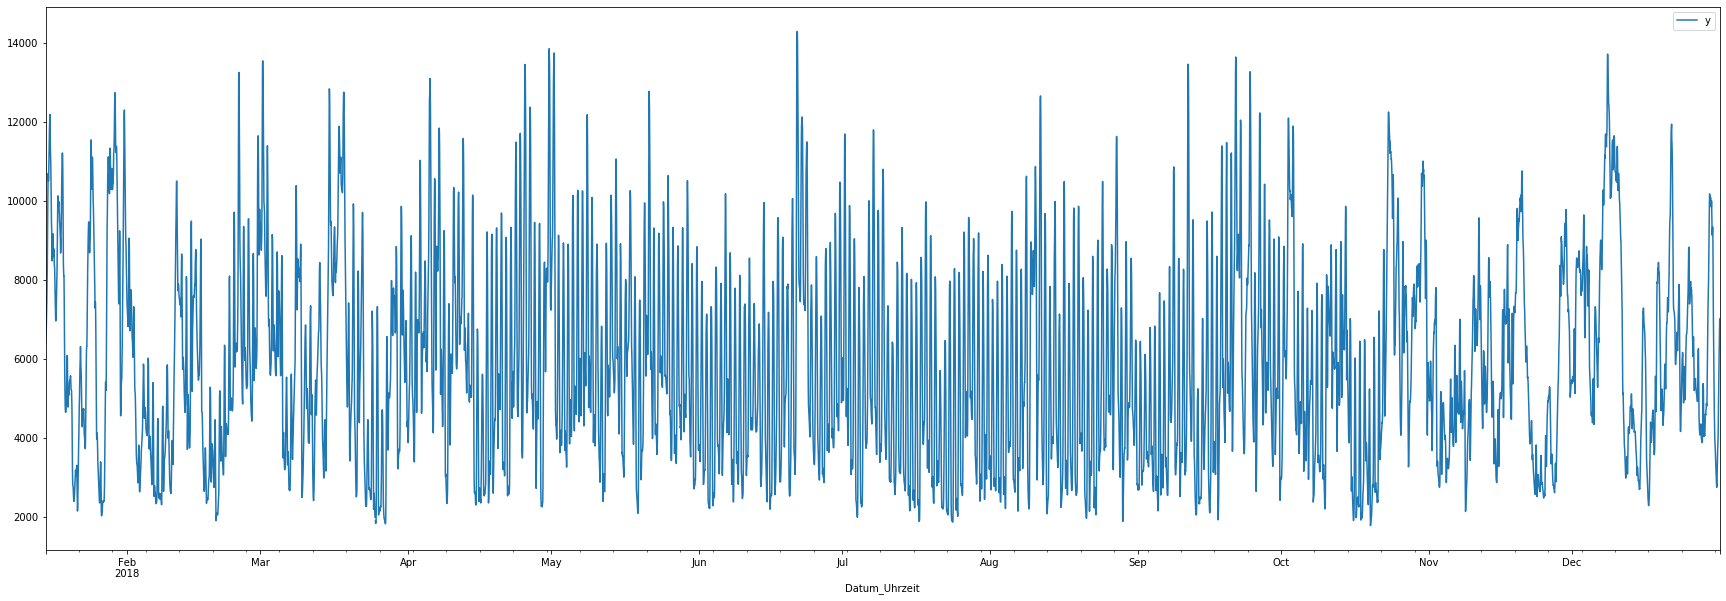

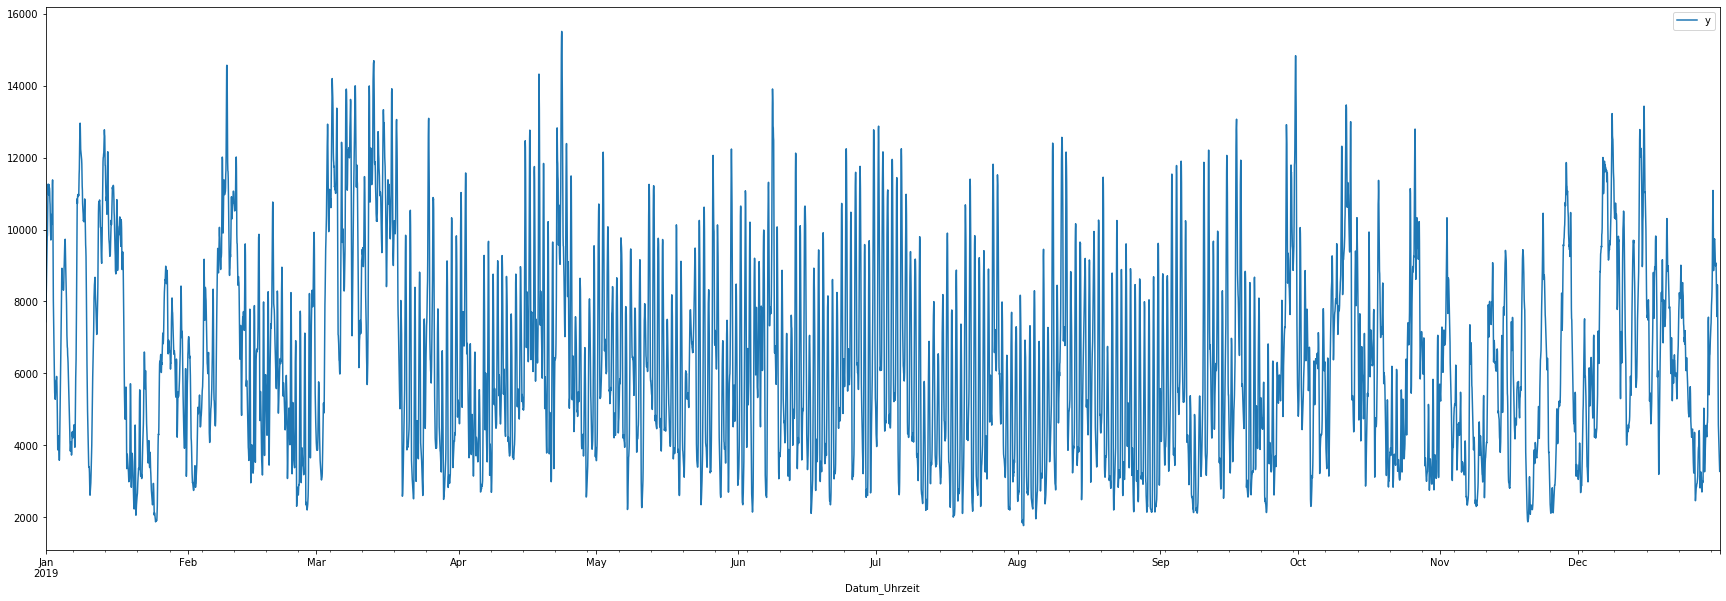

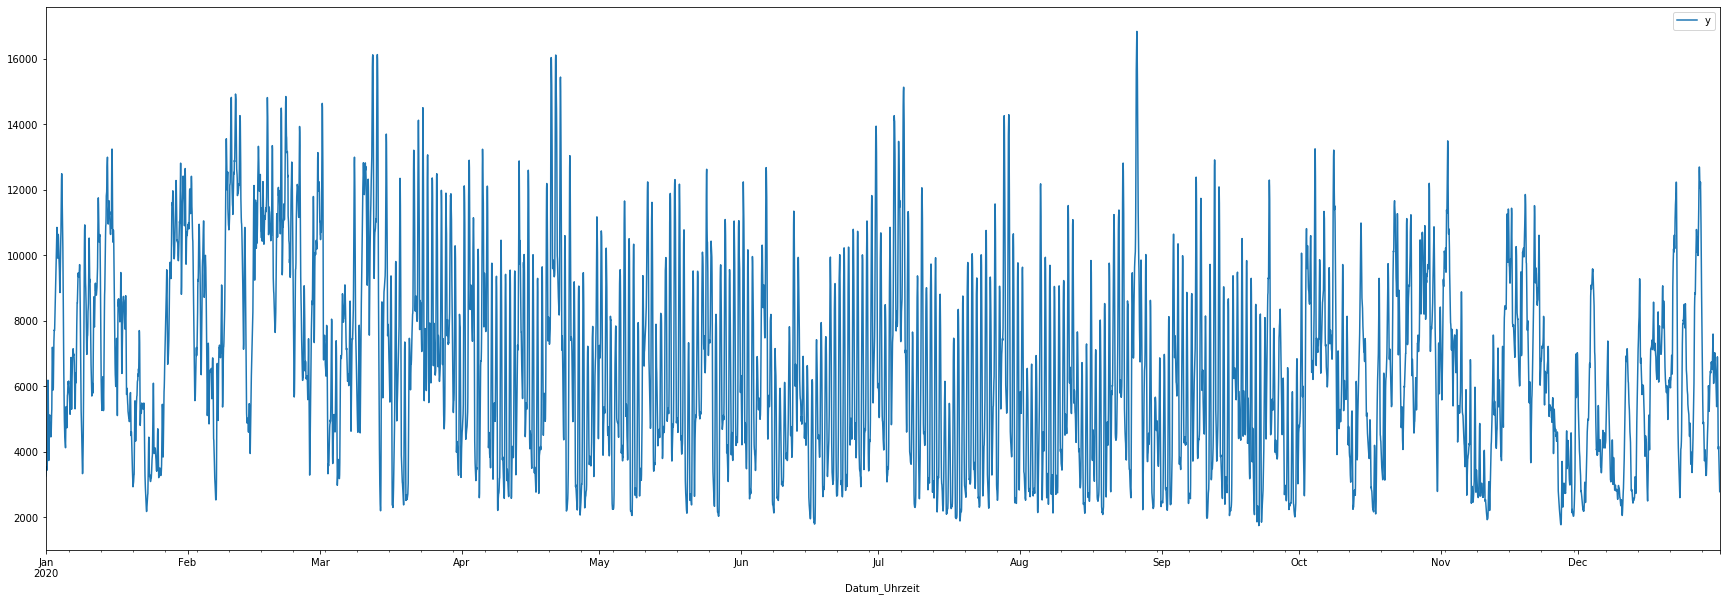

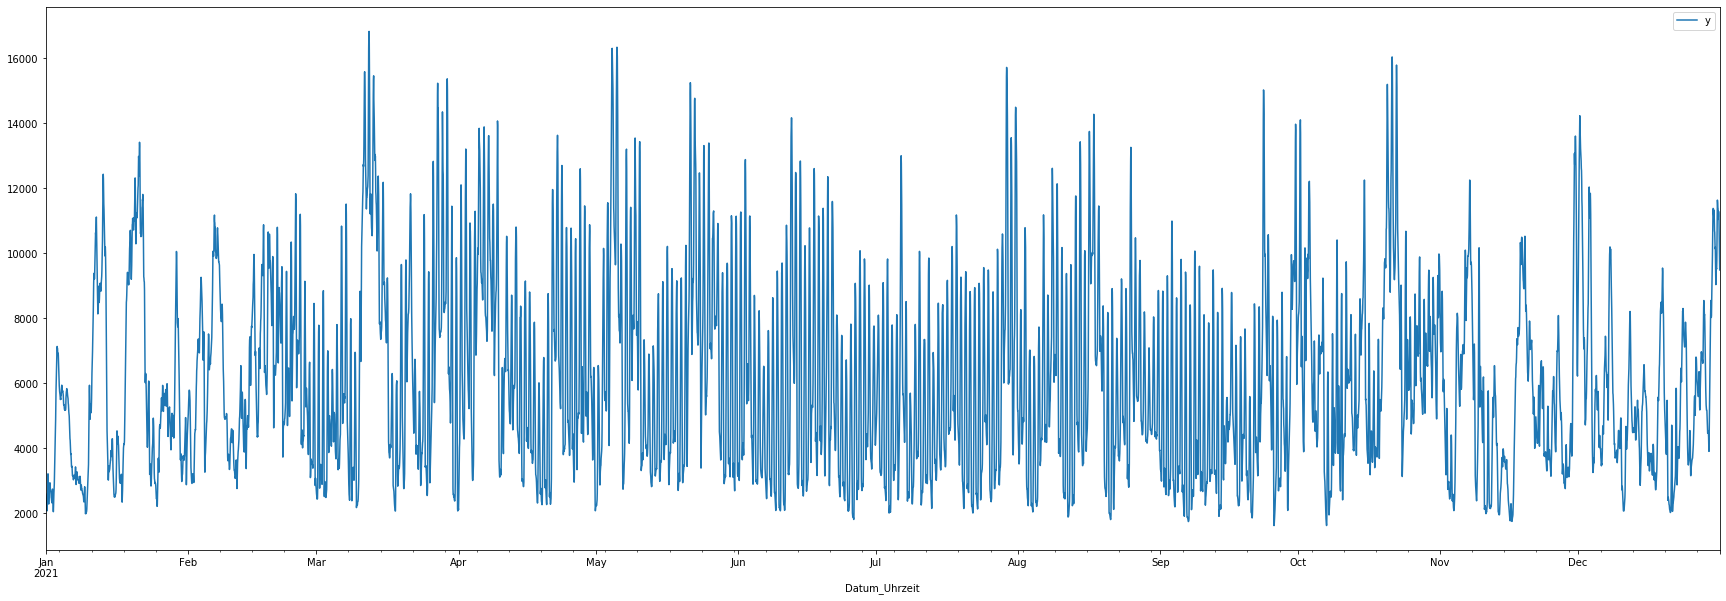

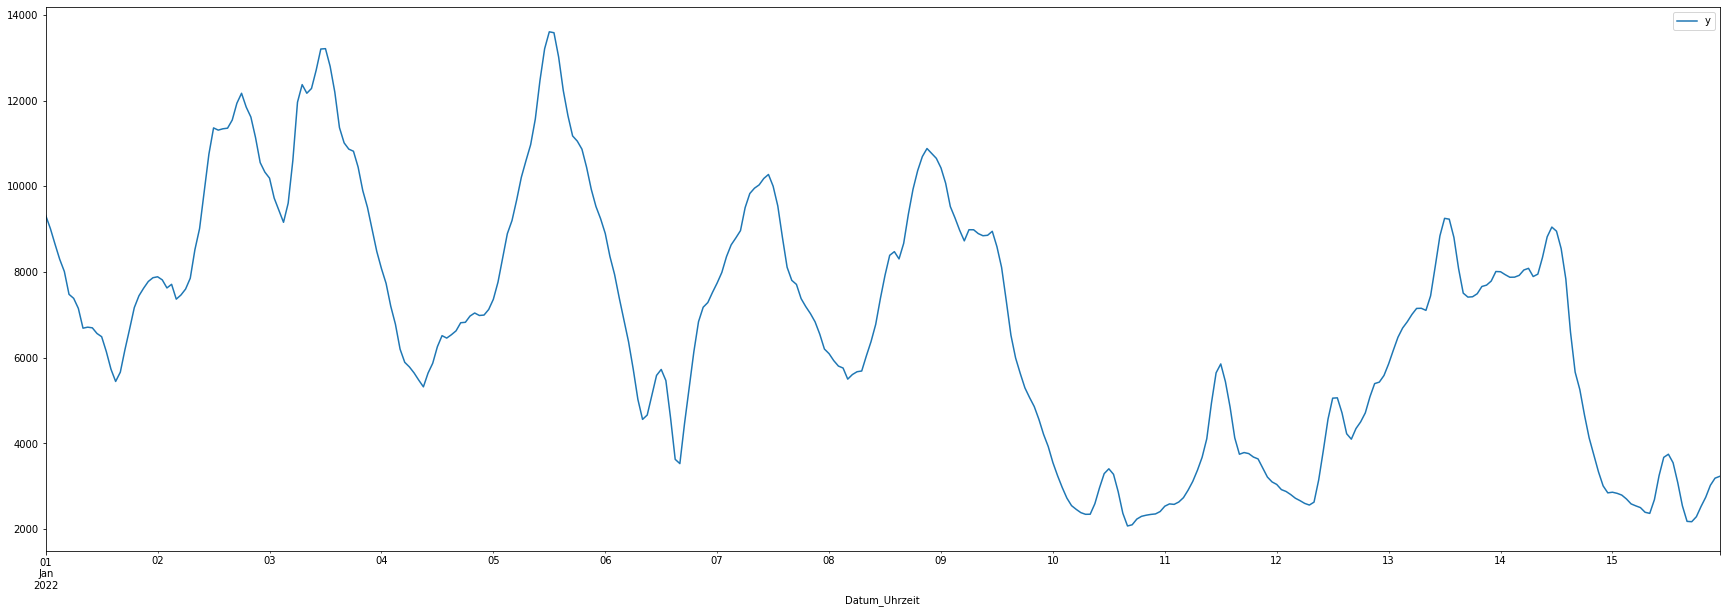

In [17]:
years = [2018, 2019, 2020, 2021, 2022]
for year in years:
    hourly_renew.iloc[hourly_renew.index.year == year].plot()

Short Note: for the last year of data we only have the month January, hence the plot is not as dense as for the preceding years. 

Anyway, it is clear from the plots that the renewable power generation in Germany in the summer is very different from the one in the winter, which totaly makes sense, since in the summer it is mostly influenced by the sun power, which is very high during noon and 0 in the night, and in the winter it is mostly influenced by the wind power. The wind intensity usually changes within a few days, so that we get more wind power for a couple of days followed by less wind power for a couple of days and so on. Hence, it might make sense to add the season with values summer or winter as a feature. To see it more clearly, I will pick a summer and a winter month and plot these.

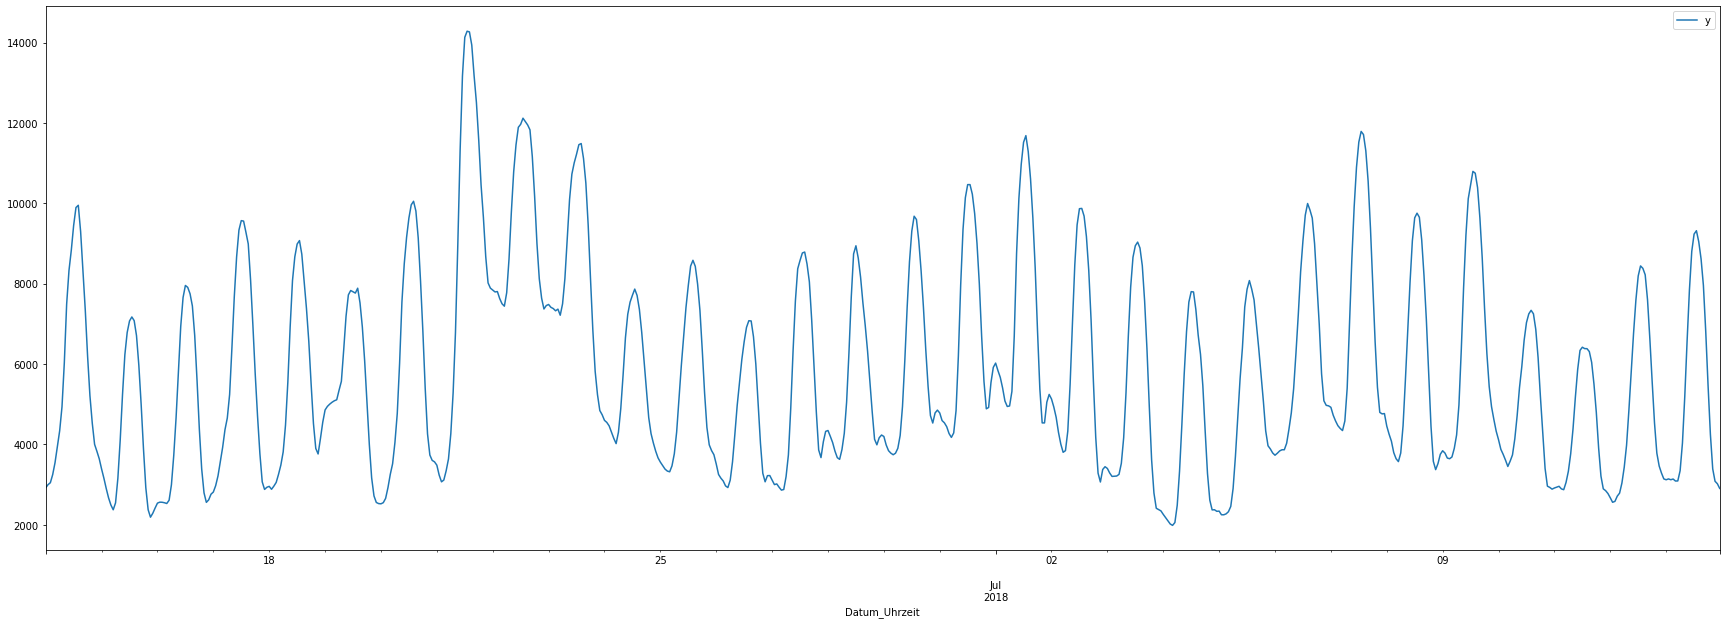

In [18]:
# a summer month
hourly_renew.iloc[150*24:180*24].plot()

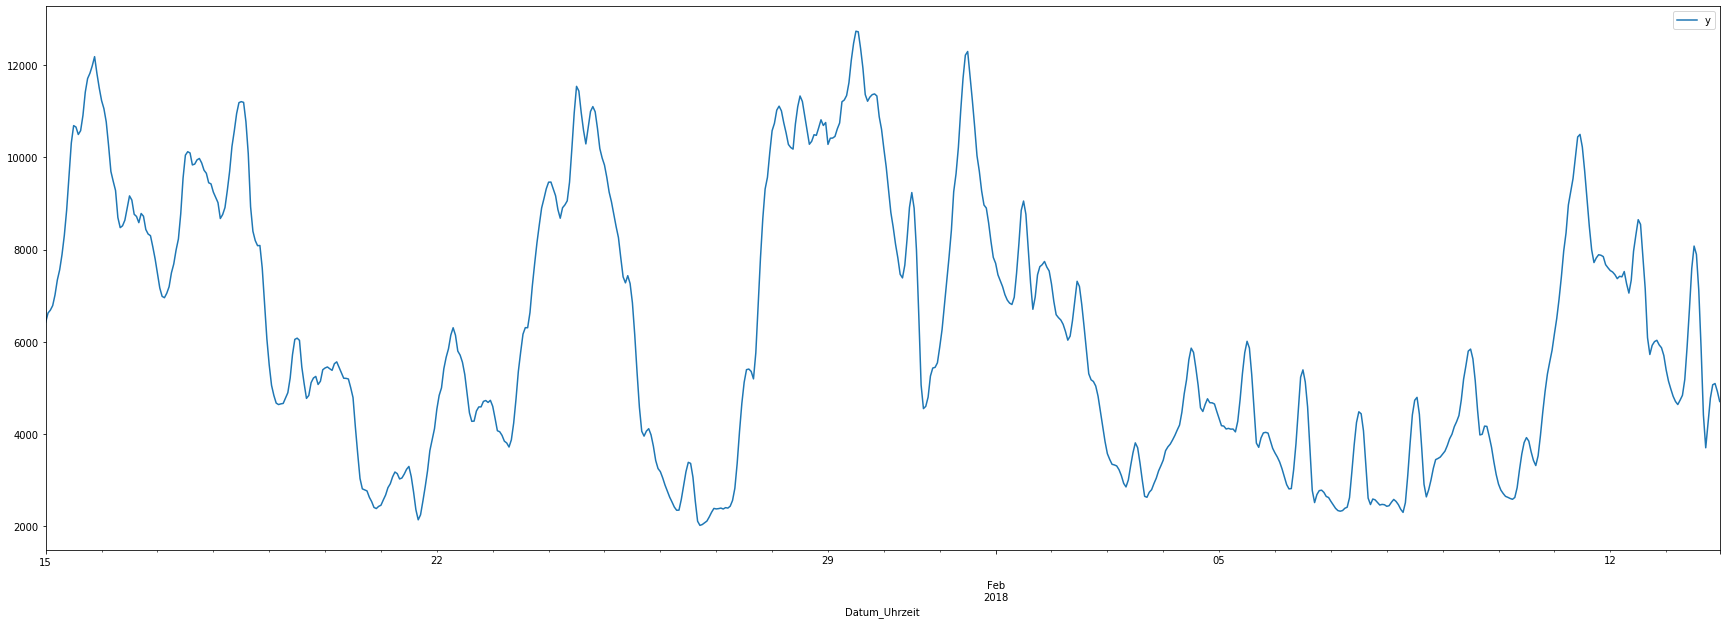

In [19]:
# a winter month
# about a month (first month of the data)
hourly_renew.iloc[:24*30].plot()

The summer month shows a lot more regularity/pattern than the winter month. The summer months' renewable power generation is clearly dominated by a daily peak at around noon. 

## Power generation per hour of the day and per month
To see this more clearly, I want to group the renewable power generation per hour for every month and look how it is distributed over the day, then plot it with seaborn lineplots. I will take the 12 months of the year and plot the hourly renewable power generation for each year in the data with the hours of the day on the x-axis and the average renewable power generation of that hour of the day in the months January through December. Since the data points start in January 2018 and end in January 2022, for January I will have 5 lines and for the other months only 4. The plot aggregates over multiple y values at each value of x and shows an estimate of the central tendency and a confidence interval for that estimate.

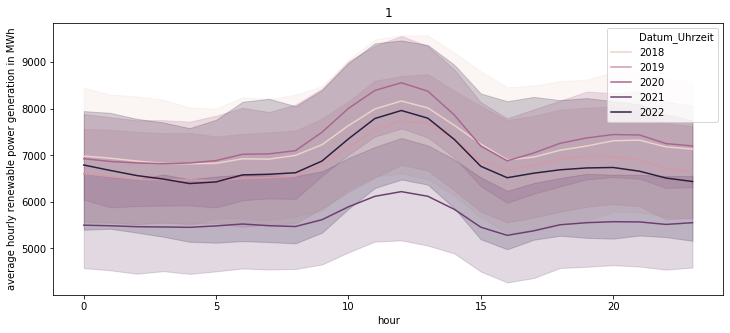

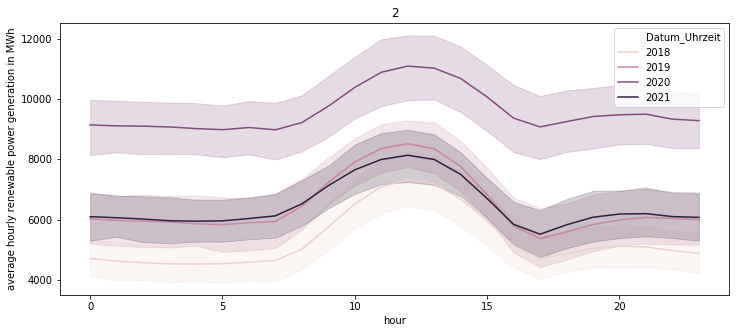

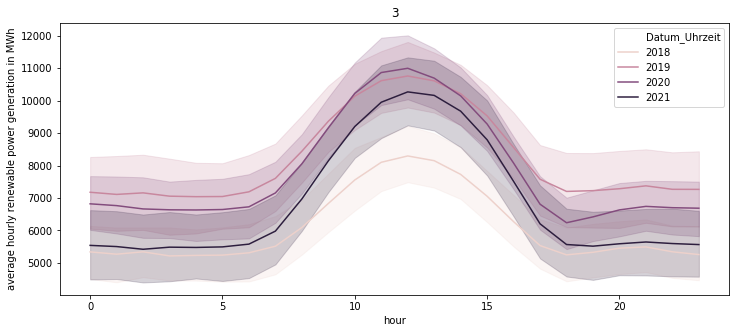

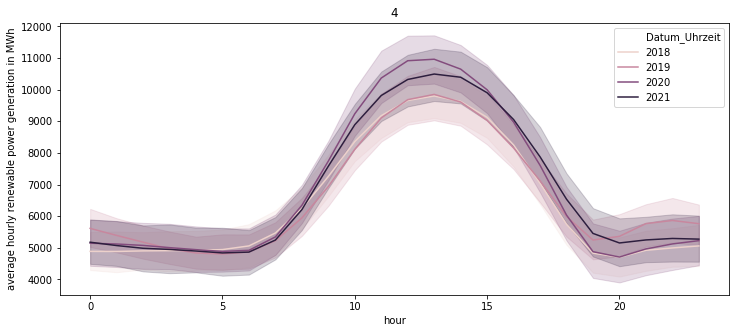

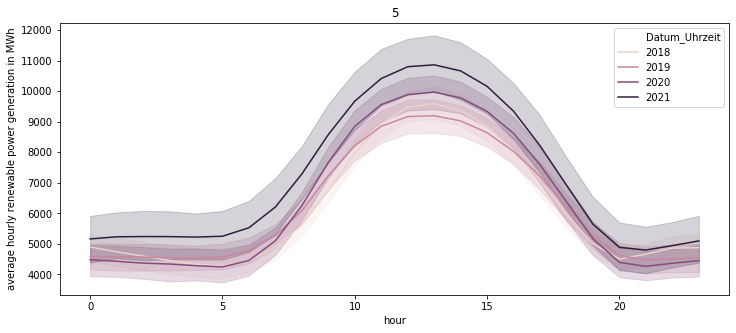

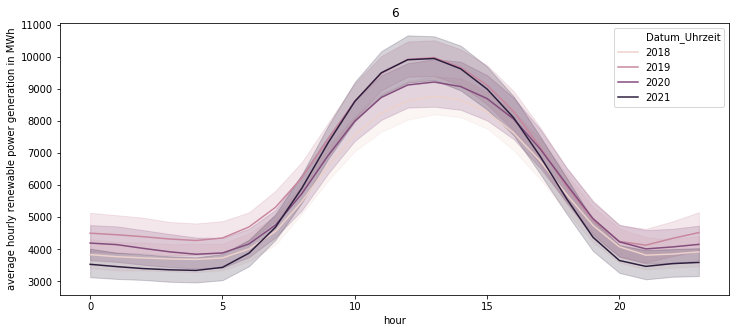

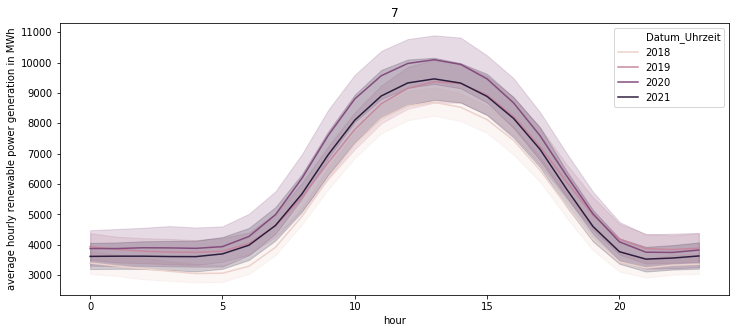

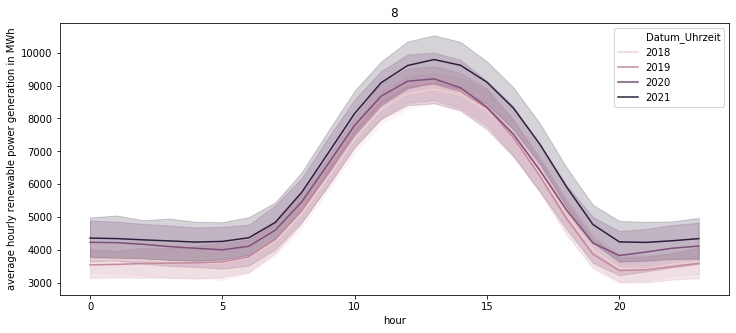

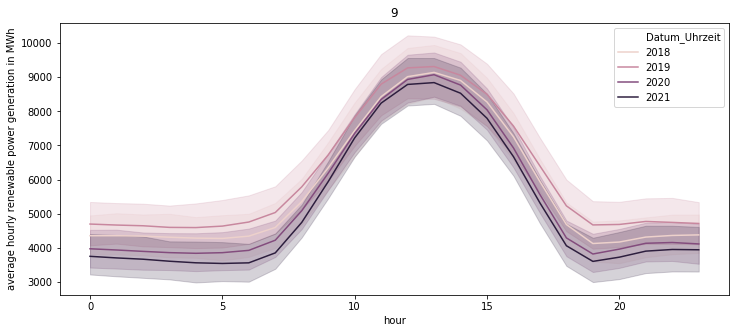

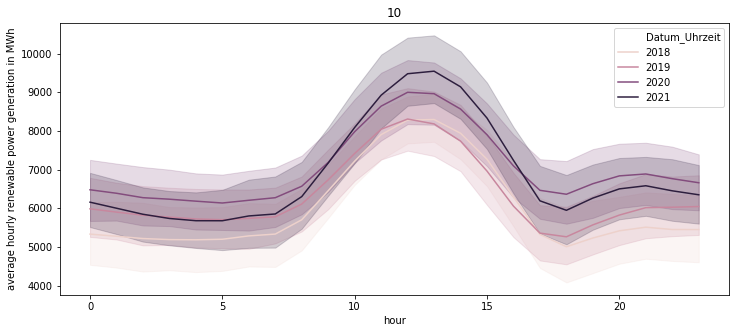

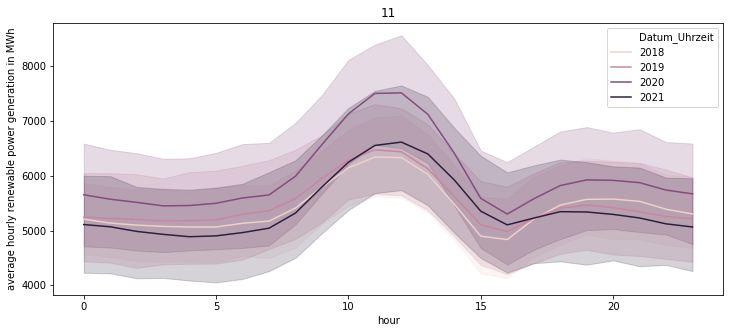

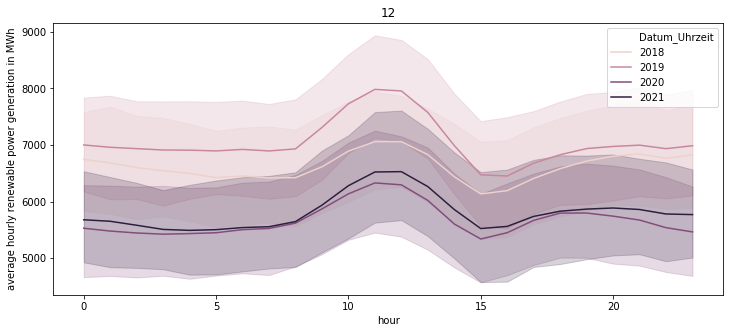

In [20]:
# hourly generation in each month (a 'typical' day for the month with range between days)
plt.rcParams['figure.figsize'] = [12, 5]
for month in range(1,13):
    month = month
    plt.figure(month)
    p = sns.lineplot(data=hourly_renew.iloc[hourly_renew.index.month==month],
                 x=hourly_renew.iloc[hourly_renew.index.month==month].index.hour,
                 y='y',
                 hue=hourly_renew.iloc[hourly_renew.index.month==month].index.year,
                 legend='full')
    # add title
    plt.title(month)
    # labels
    p.set_xlabel('hour')
    p.set_ylabel('average hourly renewable power generation in MWh')

As can be easily seen in these plots the bell curve around noon is typical for the summer days and there is not as much deviation for the hourly power generation between the days as for the winter days, where the daily shape is messier and the shadows around the line are wider.


### Trends and distribution of the renewable power generation
When is the renewabele power generation the highest?
What are the months with the most renewable power generation? Or is it more or less evenly distirbuted over the year? Is there a yearly trend?

In [21]:
# take a copy of the hourly renewable energy dataframe
hourly_monthly = hourly_renew.copy()
# add time of the day and month of the date
hourly_monthly['hour'] = hourly_monthly.index.hour
hourly_monthly['month'] = hourly_monthly.index.month

In [22]:
# group by hour and month
hourly_monthly = hourly_monthly.groupby(['month', 'hour']).mean().unstack()

Text(195.0, 0.5, 'month of the year')

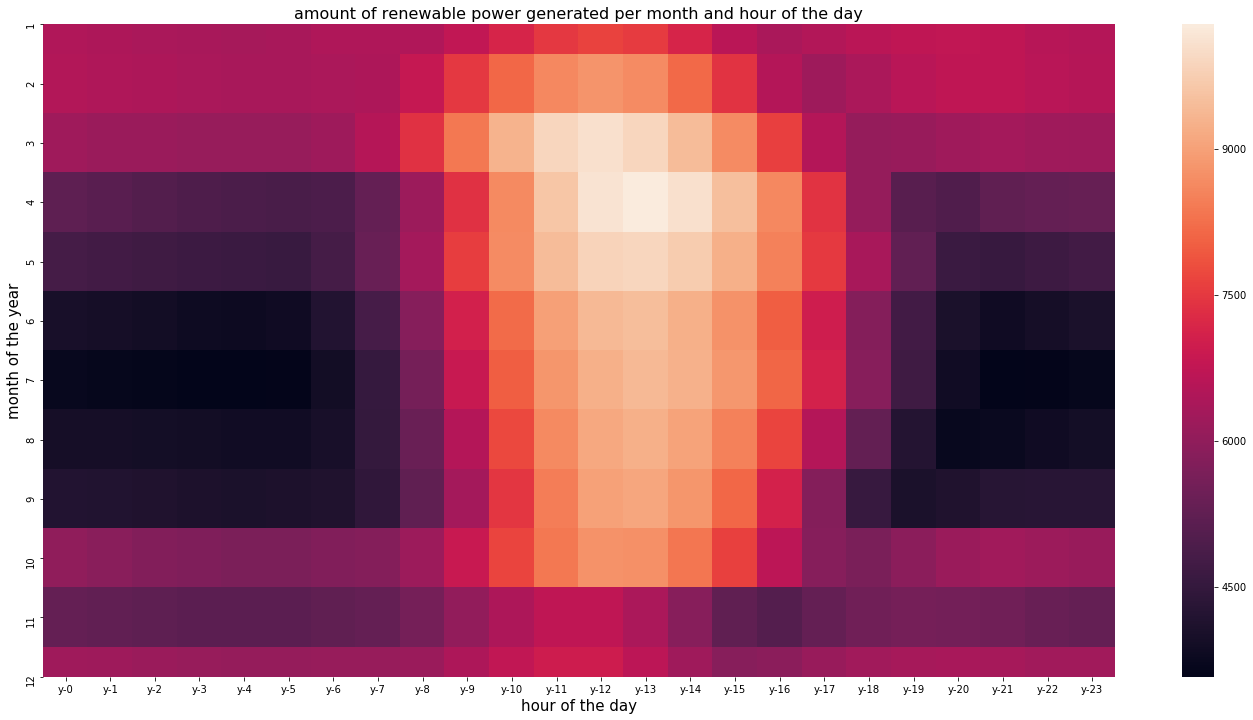

In [23]:
# plot this in a heatmap
f, ax = plt.subplots(figsize=(24,12))

ax.set_title('amount of renewable power generated per month and hour of the day', fontsize=16)

sns.heatmap(hourly_monthly)

ax.set_xlabel('hour of the day', fontsize=15)
ax.set_ylabel('month of the year', fontsize=15)

We see that especially during the summer months the deviation between the day and night is extremely high, while during the months October through March the renewable power generation is distributed more evenly over the hour of the day (well, as we have seen before also there will be more deviation between the days). In the summer months the highest amount of renewable power generation with more than 10,000 MWh is around noon and during the night it is less than 5,000 MWh. In the months November, December and January it ranges between 6,000 and 8,000 MWh. For the months February, March and October the renewable power generation is already quite high around noon, while still remaining quite high in the night. This reflects the fact that in these months the sun already shines more around noon and it is still quite windy like during the winter months. Hence, these months must be the ones with the most renewable power generated. Let's look at the sum for every month.


In [24]:
# months with the most renewable power generation
monthly = hourly_renew.copy()
monthly['month'] = monthly.index.month
monthly = monthly.groupby('month').mean()

In [29]:
fig = px.bar(monthly, title = 'average renewable power generation per month in kWh')
fig.show()

We can see that during the summer months June through September less renewable power is generated than during the winter months. And also the data confirms the above hypothesis that February, March and October are the months with the most renewable power generation.

Is there also a yearly trend?


In [32]:
# how much energy was produced in the years on average?
# months with the most renewable power generation
yearly = hourly_renew.copy()
yearly['year'] = yearly.index.year
yearly = yearly.groupby('year').mean()
# plot
fig = px.bar(yearly, title = 'average renewable power generation per year in kWh')
fig.show()

There seem to be no clear yearly trend. The years 2018 and 2022 are not complete in the data, so that we better ignore those averages (for 2018 the first 15 days are missing and for 2022 only the first 15 days are present). While in the year 2020 more renewable energy was produced than in 2019, in the following year 2021 the amount dropped even compared to the year 2019.

We have seen, that the data shows multiple seasonal effects (daily especially in summer/ summer, winter etc.). Facebook developed a forecasting procedure called prophet that works best with time series that have strong seasonal effects and several seasons of historical data. I will use it to forecast the hourly renewable power generation.

## Try prediction with prophet without extra regressors
For performing a forecast fbprophet needs the data to be in a pandas dataframe with two columns: ds (in a date or datetime format) and y (target variable). So I need to rename the datetime column 'Datum_Uhrzeit' to 'ds' in my dataframe df_renew. 

Next I need to split the data into a training and test set, instantiate the model, fit it and test it on the test set. I will keep the last year of the data for testing, i.e. the last 365 * 24 = 8760 data points.

In [34]:
# rename the datetime column
hourly_renew.index.rename('ds', inplace=True)

In [36]:
# first separate train and test data: first 3 years for training, remaining one year for test
# so training is until Jan 15th of 2021
test_size = 8760
df_train = hourly_renew[:-test_size]
df_test = hourly_renew[-test_size:]

In [37]:
df_train.tail()

,y
ds,
2021-01-15 19:00:00,2936.00
2021-01-15 20:00:00,2758.50
2021-01-15 21:00:00,2589.50
2021-01-15 22:00:00,2537.25
2021-01-15 23:00:00,2502.25


In [38]:
df_test.head()

,y
ds,
2021-01-16 00:00:00,2500.50
2021-01-16 01:00:00,2535.75
2021-01-16 02:00:00,2515.75
2021-01-16 03:00:00,2505.50
2021-01-16 04:00:00,2545.25
